In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
import hdbscan
cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*100
sns.set(style="white")

In [2]:
df = pd.read_csv('twitter_posts.csv')

In [3]:
print(df.shape)

(1803, 6)


In [4]:
df.head(10)

,Date,Username,longitude,latitude,city,country
0,2023-03-18 16:28:04+00:00,RokebyM,67.997691,6.622513,India',India
1,2023-03-18 11:20:07+00:00,watwijm,94.944302,26.649359,Arunachal Pradesh,India
2,2023-03-18 11:05:10+00:00,travelwitharyan,72.206516,27.698326,Bikaner,India
3,2023-03-18 11:03:32+00:00,travelwitharyan,72.206516,27.698326,Bikaner,India
4,2023-03-18 08:44:42+00:00,NSivapriyan2141,77.312066,8.230492,Padmanabhapuram,India
5,2023-03-17 14:38:59+00:00,tourism_udupi,74.667323,13.086056,Udupi,India
6,2023-03-17 12:05:03+00:00,onsvlogs,85.832496,21.544342,West Bengal,India
7,2023-03-17 07:28:46+00:00,RokebyM,67.997691,6.622513,India',India
8,2023-03-17 02:31:04+00:00,jaydeep_dey03,90.939097,25.722728,Guwahati,India
9,2023-03-16 16:16:44+00:00,flywithheritage,77.882808,30.227984,Dehradun,India


In [5]:
print(df.isnull().sum())
df.dropna(inplace=True)
print(df.shape)

Date         0
Username     0
longitude    0
latitude     0
city         0
country      6
dtype: int64
(1797, 6)


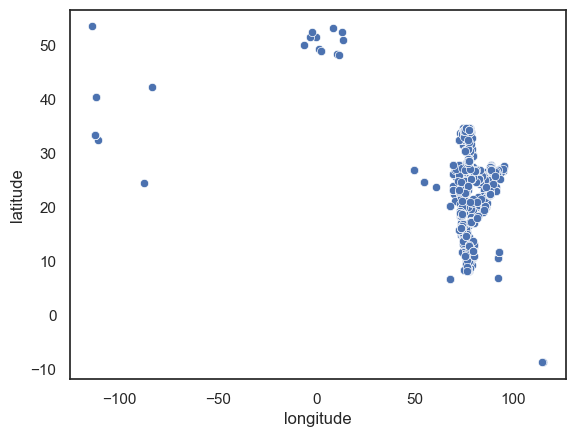

In [6]:
sns.scatterplot(x="longitude", y = "latitude", data = df)
plt.show()

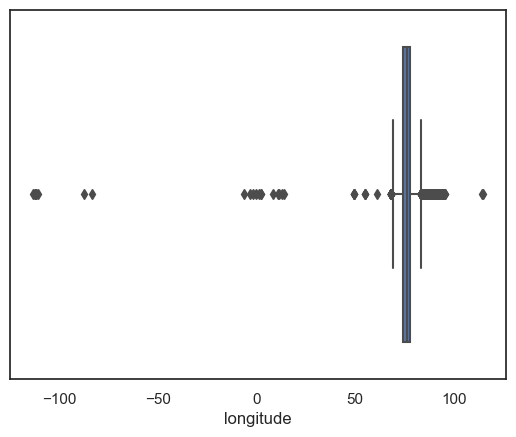

In [7]:
sns.boxplot(x="longitude", data=df)
plt.show()

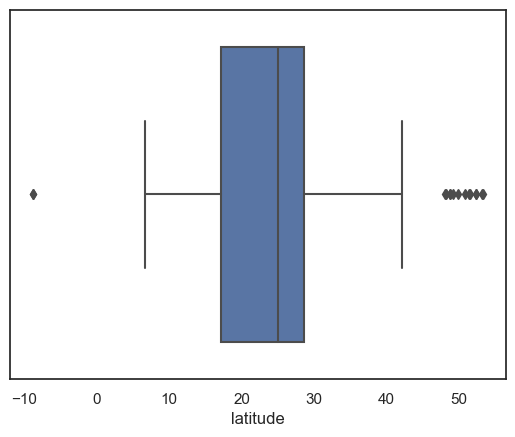

In [8]:
sns.boxplot(x="latitude", data=df)
plt.show()

### Handle Outliers using (interquartile Range) IQR

In [9]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_964/1567037959.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_964/1567037959.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_964/1567037959.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1

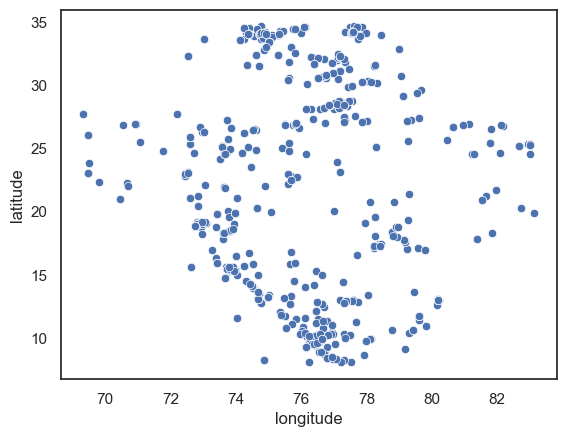

In [10]:
sns.scatterplot(x="longitude", y = "latitude", data = df)
plt.show()

### Scale the data using MinMaxScaler

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import calinski_harabasz_score
scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df[['longitude','latitude']]), columns=['longitude', 'latitude'])

In [12]:
print(df_scaled.shape)

(1441, 2)


In [13]:
df_combined = df_scaled

### K-Means Clustering

In [14]:
kmeans= KMeans(n_clusters=4, random_state=0).fit(df_scaled)
df_scaled['kmeans_labels'] = kmeans.labels_

print("Silhouette Score for K-Means: ", silhouette_score(df_scaled[['longitude', 'latitude']], kmeans.labels_))
print("RMSE for K-Means: ", mean_squared_error(df_scaled[['longitude', 'latitude']], kmeans.cluster_centers_[kmeans.labels_]))
print("Calinsky Harabasz score for K-Means", calinski_harabasz_score(df_scaled[['longitude','latitude']], kmeans.labels_))

Silhouette Score for K-Means:  0.47403755362182387
RMSE for K-Means:  0.011975818582581003
Calinsky Harabasz score for K-Means 2066.101942626772


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### DBSCAN Clustering

In [15]:
dbscan = DBSCAN(eps=0.5, min_samples=2).fit(df_scaled)
df_scaled["dbscan_labels"] = dbscan.labels_

print("Silhouette Score for DBSCAN: ", silhouette_score(df_scaled[['longitude', 'latitude']], dbscan.labels_))
# print("RMSE for DBSCAN: ", mean_squared_error(df_scaled[['longitude', 'latitude']], np.zeros_like(dbscan.labels_)))

assigned_points = dbscan.labels_ != -1
# y_true = kmeans.labels_[kmeans.labels_ != -1].reshape(-1)
y_true = df_scaled[['longitude', 'latitude']].values
y_true = y_true.reshape(-1,2)[:,0]
y_pred = dbscan.labels_[assigned_points].reshape(-1)


# print(f"y_true shape: {y_true.shape}")
# print(f"y_pred shape: {y_pred.shape}")

# # Check for missing values
# print(f"Number of missing values in y_true: {np.isnan(y_true).sum()}")
# print(f"Number of missing values in y_pred: {np.isnan(y_pred).sum()}")


# # Check number of assigned points
# num_assigned = sum(assigned_points)
# print(f"Number of assigned points: {num_assigned}")

# # Check number of unique labels
# unique_labels = set(dbscan.labels_)
# print(f"Unique labels: {unique_labels}")

# num_original = len(df)
# print(f"Number of points in original DataFrame: {num_original}")

# # Check number of points in filtered DataFrame
# num_filtered = sum(assigned_points)
# print(f"Number of points in filtered DataFrame: {num_filtered}")

# # Print length and first few elements of y_true and y_pred
# print(f"Length of y_true: {len(y_true)}")
# print(f"Length of y_pred: {len(y_pred)}")
# print(f"First few elements of y_true: {y_true[:5]}")
# print(f"First few elements of y_pred: {y_pred[:5]}")


# Calculate RMSE
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f"DBSCAN RMSE: {rmse}")

print("Calinsky Harabasz score for DBSCAN: ", calinski_harabasz_score(df_scaled[['longitude','latitude']], dbscan.labels_))

Silhouette Score for DBSCAN:  0.47403755362182387
DBSCAN RMSE: 1.531017403300455
Calinsky Harabasz score for DBSCAN:  2066.101942626772


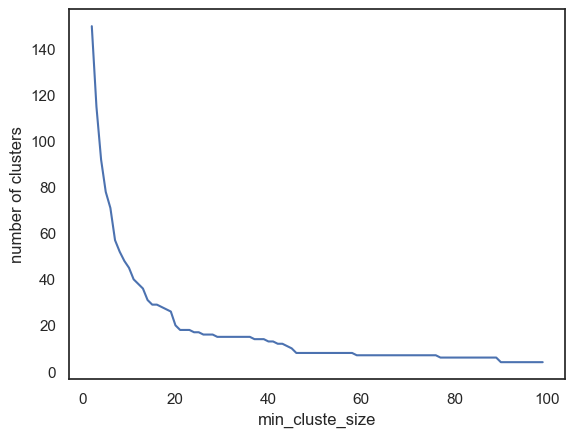

In [16]:
min_cluster_size_hdb = range(2,100)
n_clusters = []

for size in min_cluster_size_hdb:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
    clusterer.fit(df_scaled)
    n_clusters.append(len(np.unique(clusterer.labels_)))

plt.plot(min_cluster_size_hdb, n_clusters)
plt.xlabel('min_cluste_size')
plt.ylabel('number of clusters')
plt.show()

In [17]:
min_samples_range = range(2, 20)

# Fit DBSCAN with different min_samples values and calculate silhouette score for each
silhouette_scores = []
for min_samples in min_samples_range:
    dbscan = DBSCAN(eps=0.5, min_samples=min_samples)
    dbscan.fit(df_scaled)
    labels = dbscan.labels_
    if len(np.unique(labels)) > 1:  # Exclude cases with only one cluster
        score = silhouette_score(df_scaled, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(0)

# Find the index of the max silhouette score
max_index = np.argmax(silhouette_scores)

# Print the optimal min_samples value and corresponding silhouette score
print("Optimal min_samples value:", min_samples_range[max_index])
print("Corresponding silhouette score:", silhouette_scores[max_index])



Optimal min_samples value: 2
Corresponding silhouette score: 0.8970095890580685


### HDBSCAN Clustering

In [18]:
hdb = hdbscan.HDBSCAN(min_samples=2, min_cluster_size=16).fit(df_scaled[['longitude', 'latitude']])
df_scaled['hdbscan_labels'] = hdb.labels_

assigned_points_hdb = hdb.labels_ != -1
y_true_hdb = df_scaled[['longitude', 'latitude']].values
y_true_hdb = y_true_hdb.reshape(-1,2)[:,0]
y_pred_hdb = hdb.labels_.reshape(-1)



# print(f"y_true shape: {y_true_hdb.shape}")
# print(f"y_pred shape: {y_pred_hdb.shape}")

# # Check for missing values
# print(f"Number of missing values in y_true: {np.isnan(y_true_hdb).sum()}")
# print(f"Number of missing values in y_pred: {np.isnan(y_pred_hdb).sum()}")


# # Check number of assigned points
# num_assigned_hdb = sum(assigned_points_hdb)
# print(f"Number of assigned points: {num_assigned_hdb}")

# # Check number of unique labels
# unique_labels_hdb = set(hdb.labels_)
# print(f"Unique labels: {unique_labels_hdb}")

# num_original = len(df)
# print(f"Number of points in original DataFrame: {num_original}")

# # Check number of points in filtered DataFrame
# num_filtered_hdb = sum(assigned_points_hdb)
# print(f"Number of points in filtered DataFrame: {num_filtered_hdb}")

# # Print length and first few elements of y_true and y_pred
# print(f"Length of y_true: {len(y_true_hdb)}")
# print(f"Length of y_pred: {len(y_pred_hdb)}")
# print(f"First few elements of y_true: {y_true_hdb[:5]}")
# print(f"First few elements of y_pred: {y_pred_hdb[:5]}")



rmse_hdb = mean_squared_error(y_true_hdb, y_pred_hdb, squared=False)

print("Silhouette Score for HDBSCAN: ", silhouette_score(df_scaled[['longitude', 'latitude']], hdb.labels_))
print("RMSE for HDBSCAN: ", rmse_hdb)
print("Calinsky Harabasz score for HDBSACN: ", calinski_harabasz_score(df_scaled[['longitude', 'latitude']], hdb.labels_))

Silhouette Score for HDBSCAN:  0.4631434782943341
RMSE for HDBSCAN:  17.485808792917233
Calinsky Harabasz score for HDBSACN:  242.80187663936024


In [19]:
df_scaled.head()

,longitude,latitude,kmeans_labels,dbscan_labels,hdbscan_labels
0,0.208303,0.739070,0,0,7
1,0.208303,0.739070,0,0,7
2,0.577878,0.005776,2,1,30
3,0.386433,0.188670,2,1,28
4,0.619192,0.834355,3,2,15


In [20]:
from sklearn.decomposition import PCA

# Perform PCA on the data
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_combined)

# Apply KMeans clustering to the transformed data
kmeans_final = KMeans(n_clusters=4)
kmeans.fit(df_pca)
kmeans_labels = kmeans.labels_
sil_kmeans = silhouette_score(df_pca, kmeans_labels)
print("Silhouette for K-Means: ",sil_kmeans)

# Apply DBSCAN clustering 
eps_range = np.arange(0.1, 1, 0.1)
min_samples_range = range(2, 20)
silhouette_scores_dbscan = []
for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(df_pca)
        labels = dbscan.labels_
        if len(labels) > 1:  # Exclude cases with only one cluster
            score = silhouette_score(df_pca, labels)
            silhouette_scores_dbscan.append((eps, min_samples, score))
best_eps, best_min_samples, _ = max(silhouette_scores_dbscan, key=lambda x: x[2])
dbscan = DBSCAN(eps=0.5, min_samples=best_min_samples)
dbscan.fit(df_pca)
dbscan_labels = dbscan.labels_
max_index_db = max([score for _, _, score in silhouette_scores_dbscan])
print("Best eps: ", best_eps)
print("Best min_samples: ", best_min_samples)
print("DBSCAN Silhouette Score: ", max_index_db)
db_ch_score = calinski_harabasz_score(df_pca, dbscan_labels)
print(f"DBSCAN Calinsky Harabasz score: {db_ch_score}")
true_labels_db = df_combined[['longitude','latitude']].values  # Replace "label" with the actual label column name
true_labels_db = true_labels_db.reshape(-1,2)[:,0]
db_rmse_score = mean_squared_error(true_labels_db, dbscan_labels)
print(f"DBSCAN RMSE: {db_rmse_score}")
print("###########################################")


# Apply HDBSCAN clustering and determine the optimal value of min_cluster_size
min_cluster_size_range = range(2, 100)
silhouette_scores_hdb = []
for min_cluster_size in min_cluster_size_range:
    hdbscan_labels = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size).fit_predict(df_pca)
    score = silhouette_score(df_pca, hdbscan_labels)
    silhouette_scores_hdb.append((min_cluster_size, score))
best_min_cluster_size, _ = max(silhouette_scores_hdb, key=lambda x: x[1])
hdbscan_labels = hdbscan.HDBSCAN(min_samples=2,min_cluster_size=best_min_cluster_size).fit_predict(df_pca)
max_index_hdb = max([score for _, score in silhouette_scores_hdb])
print("min_cluster: ", best_min_cluster_size)
print("HDBSCAN Silhouette Score: ", max_index_hdb)
hdb_ch_score = calinski_harabasz_score(df_pca, hdbscan_labels)
print(f"HDBSCAN Calinsky Harabasz score: {hdb_ch_score}")
true_labels_hdb = df_combined[['longitude','latitude']].values  
true_labels_hdb = true_labels_hdb.reshape(-1,2)[:,0]
hdb_rmse_score = mean_squared_error(true_labels_hdb, hdbscan_labels)
print(f"HDBSCAN RMSE: {hdb_rmse_score}")
print("###########################################")

# Combine the results of the three clustering algorithms using a voting system
final_labels = np.zeros(len(df))
for i in range(len(df)):
    votes = [kmeans_labels[i], dbscan_labels[i], hdbscan_labels[i]]
    unique_votes = np.unique(votes)
    if len(unique_votes) == 1:
        final_labels[i] = unique_votes[0]
    else:
        vote_counts = [votes.count(v) for v in unique_votes]
        final_labels[i] = unique_votes[np.argmax(vote_counts)]

# Calculate the RMSE between the final labels and the true labels (if available)
true_labels = df_combined[['longitude','latitude']].values  
true_labels = true_labels.reshape(-1,2)[:,0]
rmse = mean_squared_error(true_labels, final_labels, squared=False)

# Calculate the Calinski Harabasz score for the final clustering
ch_score = calinski_harabasz_score(df_pca, final_labels)

print("Combined Method RMSE: ", rmse)
print("Calinsky Harabasz score for Combined method: ", ch_score)

silhouette_score_combined = silhouette_score(df_pca, final_labels)
print("Silhouette score for combined method:", silhouette_score_combined)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette for K-Means:  0.5768117016001577
Best eps:  0.1
Best min_samples:  2
DBSCAN Silhouette Score:  0.9943639822791551
DBSCAN Calinsky Harabasz score: 1377569.232782531
DBSCAN RMSE: 326.7841082000952
###########################################
min_cluster:  15
HDBSCAN Silhouette Score:  0.9104241255541785
HDBSCAN Calinsky Harabasz score: 751.0630360758338
HDBSCAN RMSE: 511.22309356482737
###########################################
Combined Method RMSE:  3.8613355072687385
Calinsky Harabasz score for Combined method:  1170.503521400118
Silhouette score for combined method: 0.33675831094038056


In [21]:
df_combined.head()

,longitude,latitude,kmeans_labels,dbscan_labels,hdbscan_labels
0,0.208303,0.739070,0,0,7
1,0.208303,0.739070,0,0,7
2,0.577878,0.005776,2,1,30
3,0.386433,0.188670,2,1,28
4,0.619192,0.834355,3,2,15


In [22]:
df_combined['final_labels'] = final_labels

In [23]:
int_final_labels = final_labels.astype(int)
df['final_labels'] = int_final_labels

In [24]:
df.head()

,Date,Username,longitude,latitude,city,country,final_labels
2,2023-03-18 11:05:10+00:00,travelwitharyan,72.206516,27.698326,Bikaner,India,0
3,2023-03-18 11:03:32+00:00,travelwitharyan,72.206516,27.698326,Bikaner,India,0
4,2023-03-18 08:44:42+00:00,NSivapriyan2141,77.312066,8.230492,Padmanabhapuram,India,0
5,2023-03-17 14:38:59+00:00,tourism_udupi,74.667323,13.086056,Udupi,India,0
9,2023-03-16 16:16:44+00:00,flywithheritage,77.882808,30.227984,Dehradun,India,2


In [51]:
import folium


def create_map(df, cluster_column):
    m = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=4, titles='OpenStreet Map')
    
    for _, row in df.iterrows():
        if row[cluster_column] == -1:
            cluster_color = '#000000'
        else:
            cluster_color = cols[row[cluster_column]]
        
#         icon = folium.DivIcon( icon_size=(1,1), html='<div class="marker-{}"></div>'.format(row['city'].lower().replace(" ", "-")))
        marker_div = folium.CircleMarker(location=[row['latitude'], row['longitude']],
                           radius=5,
                           popup= row['city']+ "\n" +str(row[cluster_column]),
                           color=cluster_color,
                           fill=True,
                           fill_color = cluster_color).add_to(m)
    
    folium.LayerControl().add_to(m)
    return m

m = create_map(df,'final_labels')

# # create a map object
# m = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=4)

# # iterate over the final_labels list to add tags to the map
# for _, row in df.iterrows():
#     folium.CircleMarker(location=[row.latitude, row.longitude], radius = 5, popup=row['city']+ ", " + final_labels[row]).add_to(m)
    
# create an HTML file for the map and add a search bar
m.save('map_untitled.html')

with open('map_untitled.html', 'r') as file:
    content = file.read()

def search_city(city):
    markers = m.get_root().findAll(class_='marker-icon')
    for marker in markers:
        marker_city = marker.get('class').split(' ')[1].split('-')[1].replace('-', ' ')
        if marker_city.lower() == city.lower():
            marker.style.display = 'block'
            marker.parentElement.style.display = 'block'
        else:
            marker.style.display = 'none'
            marker.parentElement.style.display = 'none'


search_function = """
<div style="position: absolute; top: 10px; left: 50%; transform: translate(-50%, 0); z-index: 1000;">
    <form id="search-form" onsubmit="searchCity(); return false;">
        <input type="text" id="search-box" placeholder="Search for a city">
        <input type="submit" value="Search">
    </form>
</div>


"""



content = content.replace('</body>', search_function + '\n</body>')

with open('map_untitled.html', 'w') as file:
    file.write(content)


Text(0.5, 0, 'Cluster Sizes')

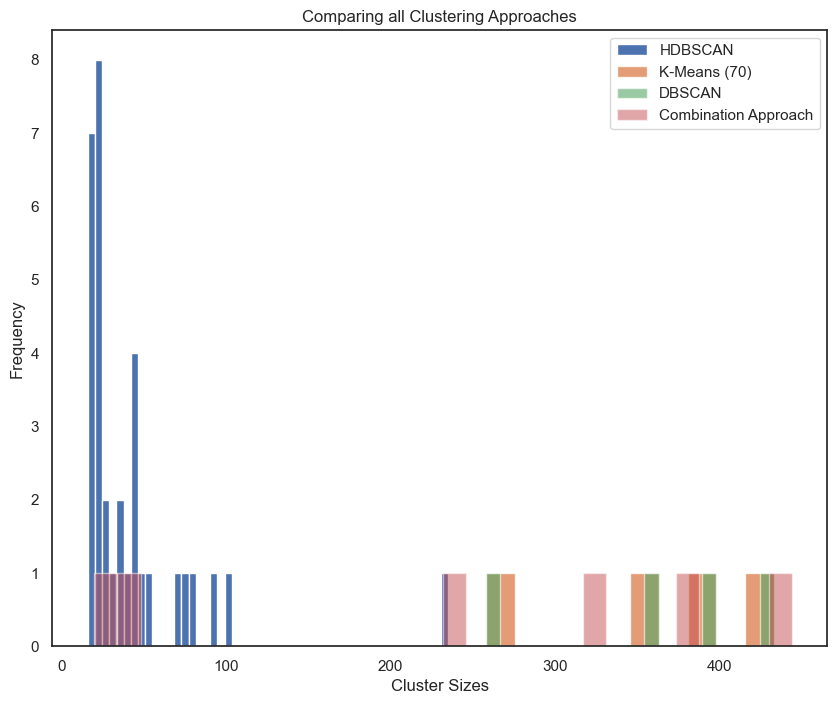

In [47]:
plt.figure(figsize=(10,8))
df_combined['hdbscan_labels'].value_counts().plot.hist(bins=50, alpha=1, 
                                              label='HDBSCAN')
df_combined['kmeans_labels'].value_counts().plot.hist(bins=10, alpha=0.8,
                                               label='K-Means')
df_combined['dbscan_labels'].value_counts().plot.hist(bins=20, alpha=0.6, label = 'DBSCAN')

df_combined['final_labels'].value_counts().plot.hist(bins=30, alpha=0.5, label = 'Combination Approach')

plt.legend()
plt.title('Comparing all Clustering Approaches')
plt.xlabel('Cluster Sizes')

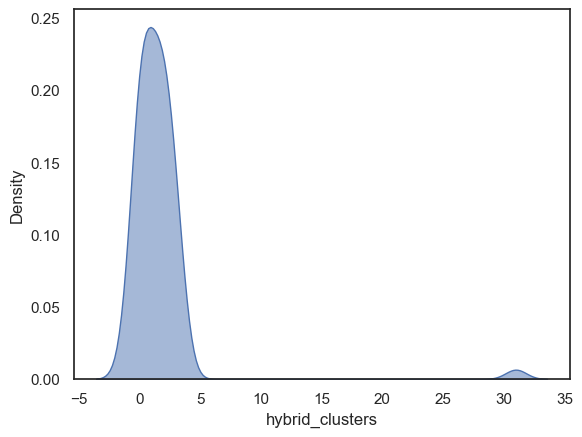

In [48]:
sns.kdeplot(data=df_combined,x='final_labels',cmap='YlOrRd',fill=True, alpha=0.5)

# plt.title(' of Twitter Posts')
plt.xlabel('hybrid_clusters')
# plt.ylabel('Latitude')
plt.show()

In [26]:
# import plotly.express as px

# # cols = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# # cols = px.colors.qualitative.Plotly[:len(labels)]
# # Create a map figure
# fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", hover_name="city", zoom=4, height=600)

# # Add the final_labels as a new trace
# fig.add_scattermapbox(lat=df['latitude'], lon=df['longitude'], mode='markers', marker=dict(size=5, color=[cols[x] for x in df['final_labels'].tolist()]))

# # Set up the search bar
# search_bar = """
# <div style="position: absolute; top: 10px; left: 50%; transform: translate(-50%, 0); z-index: 1000;">
#     <form onsubmit="searchCity(); return false;">
#         <input type="text" id="search-box" placeholder="Search for a city">
#         <input type="submit" value="Search">
#     </form>
# </div>

# <script>
# function searchCity() {
#     // get the search query from the search box
#     var searchQuery = document.getElementById('search-box').value.trim().toLowerCase();

#     // find all markers on the map
#     var markers = document.getElementsByClassName('scatterlayer')[0].getElementsByClassName('mapboxgl-marker');

#     // loop through the markers and show/hide them based on the search query
#     for (var i = 0; i < markers.length; i++) {
#         var marker = markers[i];
#         var markerCity = marker.getAttribute('data-hovertext').toLowerCase();
#         if (markerCity.includes(searchQuery)) {
#             marker.style.display = 'block';
#         } else {
#             marker.style.display = 'none';
#         }
#     }
# }
# </script>
# """

# MAPBOX_TOKEN = "pk.eyJ1Ijoic2lkbWVodGEyNyIsImEiOiJjbGhkcjFtOTAwcDZuM2VwY2ZpajNvNjVpIn0.hyTG_Wdaz9eG6Zf21lidNA"

# # Add the search bar to the figure layout
# fig.update_layout(
#     mapbox_style="open-street-map",
#     mapbox=dict(accesstoken=MAPBOX_TOKEN, zoom=4, center=dict(lat=df.latitude.mean(), lon=df.longitude.mean())),
#     hovermode='closest',
#     showlegend=False,
#     margin=dict(l=0, r=0, t=30, b=0),
#     updatemenus=[dict(type='buttons',
#                       showactive=False,
#                       buttons=[dict(label='Hide all', method='update',
#                                      args=[{'visible': False}]*len(cols)),
#                                dict(label='Show all', method='update',
#                                      args=[{'visible': True}]*len(cols))])],
#     annotations=[dict(text=search_bar, showarrow=False, xref='paper', yref='paper',
#                       x=0.5, y=1.05, align='center', font=dict(size=12))],
# )

# # Save the map as an HTML file
# fig.write_html("map_plotly.html")

In [27]:
nlp_places_df = pd.read_csv('Locations.csv')
nlp_places_df.head()

,longitude,latitude,Place
0,13.780363,8.771279,North
1,78.667743,22.351115,India
2,85.438846,23.967515,Hazaribagh
3,91.299910,25.537943,Meghalaya
4,78.085349,32.370901,Spiti


In [28]:
print(f'Before dropping values\t:\tnlp_places_df.shape = {nlp_places_df.shape}')
nlp_places_df.dropna(inplace=True)
nlp_places_df.drop_duplicates(subset = ['Place'], keep='first', inplace=True)
print(f'After dropping values\t:\tnlp_places_df.shape = {nlp_places_df.shape}')

Before dropping values	:	nlp_places_df.shape = (2059, 3)
After dropping values	:	nlp_places_df.shape = (2059, 3)


In [29]:
test_df = nlp_places_df

In [42]:
test_df.head(10)

,longitude,latitude,Place
0,13.780363,8.771279,North
1,78.667743,22.351115,India
2,85.438846,23.967515,Hazaribagh
3,91.299910,25.537943,Meghalaya
4,78.085349,32.370901,Spiti
5,77.375725,28.662881,Vasundhara
6,77.310556,28.403148,Faridabad
7,79.415481,29.294783,Nainital
8,77.489465,31.998651,Kheerganga
9,77.170973,31.104153,Shimla


In [30]:
print(nlp_places_df.isnull().sum())
nlp_places_df.dropna(inplace=True)
print(nlp_places_df.shape)

longitude    0
latitude     0
Place        0
dtype: int64
(2059, 3)


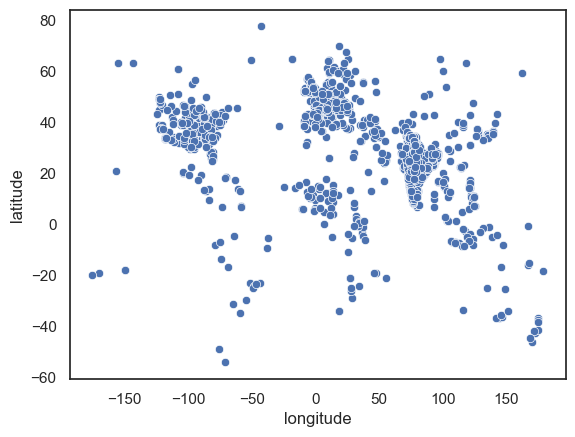

In [31]:
sns.scatterplot(x="longitude", y = "latitude", data = nlp_places_df)
plt.show()

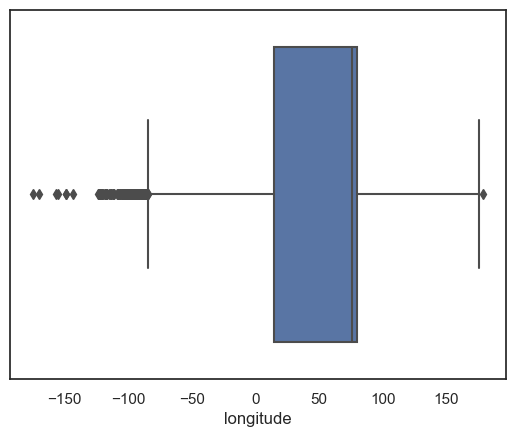

In [32]:
sns.boxplot(x="longitude", data=nlp_places_df)
plt.show()

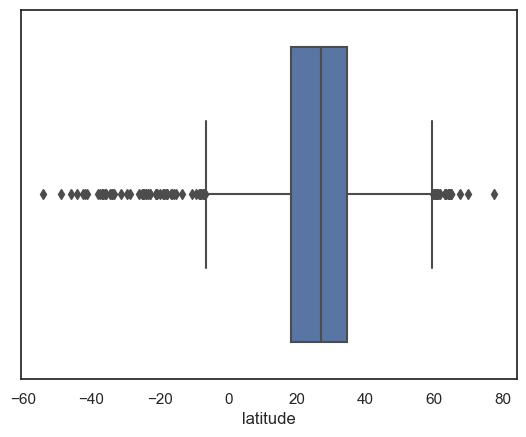

In [33]:
sns.boxplot(x="latitude", data=nlp_places_df)
plt.show()

In [40]:
Q1 = nlp_places_df.quantile(0.25)
Q3 = nlp_places_df.quantile(0.75)
IQR = Q3 - Q1

nlp_places_df = nlp_places_df[~((nlp_places_df < (Q1 - 1.5 * IQR)) | (nlp_places_df > (Q3 + 1.5 * IQR))).any(axis=1)]

/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_964/3320998107.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = nlp_places_df.quantile(0.25)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_964/3320998107.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = nlp_places_df.quantile(0.75)
/var/folders/0z/2tqs8bgj7j74q8364ll87kgw0000gn/T/ipykernel_964/3320998107.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  nlp_places_df = nlp_places_

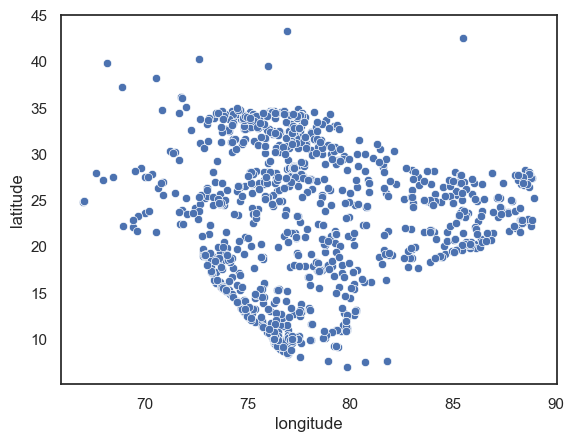

In [41]:
sns.scatterplot(x="longitude", y = "latitude", data = nlp_places_df)
plt.show()

In [52]:

scaler_nlp = MinMaxScaler()

df_scaled_nlp = pd.DataFrame(scaler.fit_transform(nlp_places_df[['longitude','latitude']]), columns=['longitude', 'latitude'])

In [53]:
print(df_scaled_nlp.shape)

(1150, 2)


In [56]:
from sklearn.decomposition import PCA

# Perform PCA on the data
pca = PCA(n_components=2)
df_pca_nlp = pca.fit_transform(df_scaled_nlp)

# Apply KMeans clustering to the transformed data
kmeans_final_nlp = KMeans(n_clusters=4)
kmeans_final_nlp.fit(df_pca_nlp)
kmeans_labels_nlp = kmeans_final_nlp.labels_
sil_kmeans_nlp = silhouette_score(df_pca_nlp, kmeans_labels_nlp)
print("Silhouette for K-Means: ",sil_kmeans_nlp)

# Apply DBSCAN clustering 
eps_range = np.arange(0.1, 1, 0.1)
min_samples_range = range(2, 20)
silhouette_scores_dbscan_nlp = []
for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan_nlp = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_nlp.fit(df_pca_nlp)
        labels_nlp = dbscan_nlp.labels_
        if len(labels_nlp) > 1:  # Exclude cases with only one cluster
            score = silhouette_score(df_pca_nlp, labels_nlp)
            silhouette_scores_dbscan_nlp.append((eps, min_samples, score))
best_eps, best_min_samples, _ = max(silhouette_scores_dbscan_nlp, key=lambda x: x[2])
dbscan_nlp = DBSCAN(eps=0.5, min_samples=best_min_samples)
dbscan_nlp.fit(df_pca_nlp)
dbscan_labels_nlp = dbscan_nlp.labels_
max_index_db = max([score for _, _, score in silhouette_scores_dbscan_nlp])
print("Best eps: ", best_eps)
print("Best min_samples: ", best_min_samples)
print("DBSCAN Silhouette Score: ", max_index_db)
db_ch_score = calinski_harabasz_score(df_pca_nlp, dbscan_labels_nlp)
print(f"DBSCAN Calinsky Harabasz score: {db_ch_score}")
true_labels_db = df_scaled_nlp[['longitude','latitude']].values  # Replace "label" with the actual label column name
true_labels_db = true_labels_db.reshape(-1,2)[:,0]
db_rmse_score = mean_squared_error(true_labels_db, dbscan_labels_nlp)
print(f"DBSCAN RMSE: {db_rmse_score}")
print("###########################################")


# Apply HDBSCAN clustering and determine the optimal value of min_cluster_size
min_cluster_size_range = range(2, 100)
silhouette_scores_hdb = []
for min_cluster_size in min_cluster_size_range:
    hdbscan_labels = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size).fit_predict(df_pca)
    score = silhouette_score(df_pca, hdbscan_labels)
    silhouette_scores_hdb.append((min_cluster_size, score))
best_min_cluster_size, _ = max(silhouette_scores_hdb, key=lambda x: x[1])
hdbscan_labels = hdbscan.HDBSCAN(min_samples=2,min_cluster_size=best_min_cluster_size).fit_predict(df_pca)
max_index_hdb = max([score for _, score in silhouette_scores_hdb])
print("min_cluster: ", best_min_cluster_size)
print("HDBSCAN Silhouette Score: ", max_index_hdb)
hdb_ch_score = calinski_harabasz_score(df_pca, hdbscan_labels)
print(f"HDBSCAN Calinsky Harabasz score: {hdb_ch_score}")
true_labels_hdb = df_combined[['longitude','latitude']].values  
true_labels_hdb = true_labels_hdb.reshape(-1,2)[:,0]
hdb_rmse_score = mean_squared_error(true_labels_hdb, hdbscan_labels)
print(f"HDBSCAN RMSE: {hdb_rmse_score}")
print("###########################################")

# Combine the results of the three clustering algorithms using a voting system
final_labels = np.zeros(len(df))
for i in range(len(df)):
    votes = [kmeans_labels[i], dbscan_labels[i], hdbscan_labels[i]]
    unique_votes = np.unique(votes)
    if len(unique_votes) == 1:
        final_labels[i] = unique_votes[0]
    else:
        vote_counts = [votes.count(v) for v in unique_votes]
        final_labels[i] = unique_votes[np.argmax(vote_counts)]

# Calculate the RMSE between the final labels and the true labels (if available)
true_labels = df_combined[['longitude','latitude']].values  
true_labels = true_labels.reshape(-1,2)[:,0]
rmse = mean_squared_error(true_labels, final_labels, squared=False)

# Calculate the Calinski Harabasz score for the final clustering
ch_score = calinski_harabasz_score(df_pca, final_labels)

print("Combined Method RMSE: ", rmse)
print("Calinsky Harabasz score for Combined method: ", ch_score)

silhouette_score_combined = silhouette_score(df_pca, final_labels)
print("Silhouette score for combined method:", silhouette_score_combined)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette for K-Means:  0.4822426029665375


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)